In [1]:
RANDOM_SEED = 42  # Pour obtenir les mêmes résultats entre deux éxécutions

# Utilisation de méthodes de classification pour la prédiction de survie de patients atteints d'insuffisance cardiaque

## Importations des bibliothèques

In [9]:
import numpy as np
import pandas as pd

# Affichages graphiques
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.inspection import DecisionBoundaryDisplay  # Pour les frontières de décision

# Division du dataset et méthodes de cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Métriques
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score , accuracy_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay

# Mise à l'échelle (Scaler)
from sklearn.preprocessing import StandardScaler

# Sauvegarde et chargement des modèles
from joblib import dump, load

# Modèles
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from xgboost import XGBClassifier  # XGBoost
from sklearn.svm import SVC  # SVM

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Fonctions utilitaires

In [44]:
"""
  Importe le jeu de données.

  Args :
    path (string)  : chemin relatif

  Returns :
     (pandas.Dataframe)  : Dataframe représentant le jeu de données

"""
def load_heart_failure_data(path='.'):
    return pd.read_csv(path+"/data/heart_failure_clinical_records_dataset.csv")

"""
  Stocke dans un dictionnaire les prédictions de modèles sur un ensemble de données et selon des métriques.

  Args :
    X_test (pandas.core.frame.DataFrame)  : Données
    y_test (pandas.core.series.Series)  : Etiquettes
    metrics (list)  : Métriques Scikit-Learn
    models (list)  : Modèles implémentant la méthode .predict()

  Returns :
    results (dict)  : Métriques des modèles sur (X_test,y_test)

"""
def compute_metrics(X_test, y_test, metrics, models):
  results = dict()
  for model in models:
    model_results = dict()  # Dictionnaire des résultats du modèle
    predictions = model.predict(X_test)  # Prédictions du modèle
    # Calcul du score de chaque métrique 
    for metric in metrics:
      model_results[metric] = metric(y_test,predictions)
    results[model] = model_results
  return results

"""
  Affiche les métriques des modèles.

  Args :
    results_dict (dict)  : Métriques des modèles
    metrics (list(sklearn.metrics))  : Métriques
    models (list())  : Modèles implémentant la méthode .predict()

"""
def print_results(results_dict, metrics, models):
  for metric in metrics:
    print(f"Pour la métrique {metric.__name__}, on a :")
    for model in models:
      print(f"  {model.__class__.__name__} : {round(results_dict[model][metric],4)}")

"""
  Renvoi un DataFrame représentant les noms des modèles comme index, les noms des métriques comme colonnes et les scores respectifs.

  Args :
    results_dict (dict)  : Métriques des modèles
    metrics (list(sklearn.metrics))  : Métriques
    models (list())  : Modèles implémentant la méthode .predict()

  Returns :
    (pandas.DataFrame)  : Dataframe des scores des modèles

"""
def dataframe_from_results(results_dict, metrics, models):
  metric_names = [metric.__name__ for metric in metrics]  # Noms des métriques (precision_score, recall_score, etc.)
  model_names = [model.__class__.__name__ for model in models]  # Noms des modèles (RandomForest, SVC, etc.)
  return pd.DataFrame([[round(results_dict[model][metric],3) for metric in metrics] for model in models],index=model_names,columns=metric_names)

"""
  Affiche les matrices de confusions sur (X_test,y_test) de chaque modèle.
  
  Args :
    X_test (np.ndarray((m,n)))  : Données à prédire
    y_test (np.ndarray((m,)))  : Etiquettes
    models (list())  : Modèles implémentant la méthode .predict()

"""
def display_confusion_matrices(X_test, y_test,  models):
  fig, axes = plt.subplots(2, 2, figsize=(14,12))  # Création de la figure
  for ax,model in zip(axes.flatten(),models):  # Pour chaque couple (axe,modèle)
    predictions = model.predict(X_test)  # Prédictions du modèle
    # Affichage de la matrice de confusion
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax)
    ax.set_title(f"{model.__class__.__name__}")

"""
  Instancie un constructeur représentant un modèle, effectue une recherche d'hyperparamètres avec GridSearch et renvoi l'historique d'entraînement.

  Args :
    X (np.ndarray((m,n)))  : Données d'entraînement
    y (np.ndarray((m,)))  : Etiquettes
    builder : Constructeur de classe (RandomForest par exemple)
    param_grid (dict)  : Grille de paramètres
    verbose (int)  : Type d'affichage
    scoring (string)  : Score à utiliser lors de la recherche
    random_state (int)  : Graine de génération

  Returns :
    history (dict)  : Historique d'entraînement

"""
def my_grid_search(X,y,builder,param_grid,verbose=1,scoring='accuracy',random_state=RANDOM_SEED):
  estimator = builder(random_state=random_state)  # Par exemple RandomForest(random_state=random_state)
  grid = GridSearchCV(estimator, param_grid, scoring=scoring, cv=skf, verbose=verbose)
  history = grid.fit(X,y)
  return history

"""
  Sauvegarde la liste de modèle dans le dossier /models avec joblib.
  Les noms des modèles correspondent à leur nom de classe.
  
  Args :
    models (list())  : Modèles implémentant la méthode .predict()
    path (string)  : Chemin relatif
    extra (string)  : Texte supplémentaire ajouté en fin de nom de fichiers

"""
def save_models(models,path='.',extra=''):
  for model in models:
    # Par exemple './models/RandomForest_scaled.joblib'
    dump(model, path+'/models/'+model.__class__.__name__+'_'+extra+'.joblib')
  del model

"""
  Charge une liste de modèles dans le dossier /models avec joblib.
  
  Args :
    builders : Constructeurs de classe
    path (string)  : Chemin relatif
    extra (string)  : Texte supplémentaire présent en fin de nom de fichiers

  Returns :
    models (list)  : Modèles

"""
def load_models(builders=builders, path='.',extra=''):
  models = []
  model_names = [builder.__name__ for builder in builders]  # i.e. [LogisticRegression, RandomForest, etc.]

  for name in model_names:
    models.append(load(path+'/models/'+name+'_'+extra+'.joblib'))

  return models

"""
  Entraîne une instance de chaque constructeur sur un ensemble d'entraînement, récupère les meilleurs modèles, puis effectue des prédictions sur un ensemble de test.
  
  Args :
    X_train (np.ndarray((,n)))  : Données d'entraînement
    X_test (np.ndarray((,n)))  : Données à prédire
    y_test (np.ndarray((,1)))  : Etiquettes d'entraînement
    y_test (np.ndarray((,1)))  : Etiquettes
    builders (list) : Liste des constructeurs de classe
    grids (list)  : Liste de grilles de paramètres
    metrics (list)  : Métriques Scikit-Learn

  Returns :
    histories (list)  : Historiques d'entraînement
    best_models (list)  : Meilleurs modèles obtenus
    results_dict (dict)  : Dictionnaire de prédictions des modèles

"""
def fit_scores(X_train, X_test, y_train, y_test, builders, grids, metrics):  
  histories = []
  best_models = []
  
  if grids == None:  # Condition utilisée uniquement pour l'approche naïve
    for builder in builders:
        model = builder(random_state=RANDOM_SEED)
        model.fit(X_train,y_train)
        best_models.append(model)
  else :
    for (builder, grid) in zip(builders,grids):
      history = my_grid_search(X_train, y_train, builder, grid)
      best_model = history.best_estimator_  # Meilleur modèle
      histories.append(history)
      best_models.append(best_model)
      
  results_dict = compute_metrics(X_test, y_test, metrics, best_models)  # Scores sur l'ensemble de test
  
  return histories, best_models, results_dict

"""
  Créer un ensemble d'entraînement (80%) et de test (20%) stratifié puis effectue une mise à l'échelle.
  
  Args :
    X (pandas.core.frame.DataFrame)  : Données
    y (pandas.core.series.Series)  : Etiquettes
    scaling (bool) : Mise à l'échelle centrée-réduite
    stratify (pandas.core.series.Series)  : Colonne de stratification
    random_state (int)  : Graine de génération

  Returns :
    X_train (np.ndarray((,n)))  : Données d'entraînement
    X_test (np.ndarray((,n)))  : Données de test
    y_train (np.ndarray((,1)))  : Etiquettes d'entraînement
    y_test (np.ndarray((,1)))  : Etiquettes de test

"""
def split_and_scale(X, y, scaling=True, stratify=None, random_state=RANDOM_SEED):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify, random_state=random_state)
  
  if scaling:
    scaler = StandardScaler()  # Centrée-réduite
    X_train = scaler.fit_transform(X_train)  
    X_test = scaler.transform(X_test)  # On applique bien les données stratistiques (moyenne, etc.) de l'ensemble d'entraînement à l'ensemble de test
  # Pour obtenir des tableaux numpy
  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()
  
  return X_train, X_test, y_train, y_test

"""
  Affiche les meilleurs paramètres d'une liste d'historiques.
  
  Args :
    histories (list)  : Historiques
    
"""
def print_params(histories):
  for history in histories:
    print(history.best_params_)
    

## Variables (globales) utilitaires

In [31]:
heart_failure = load_heart_failure_data('.')

metrics = [matthews_corrcoef, f1_score, accuracy_score, precision_score, recall_score,  roc_auc_score]
builders = [LogisticRegression, RandomForestClassifier, XGBClassifier, SVC]

features = [feature for feature in heart_failure.columns if feature not in 'DEATH_EVENT']
X = heart_failure[features]
y = heart_failure['DEATH_EVENT']

skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

log_reg_param_grid = {
    'max_iter': [25,50,100,200,400,800],  # Nombres d'itérations maximum
    'C': [0.01,0.1,1.,10,100],  # Intensités de régularisation
    # liblinear est 'un bon choix' pour les petits datasets selon la documentation sklearn
    'solver': ['lbfgs','liblinear'],  # Optimiseurs
    'class_weight': [None,'balanced']  # Modèles pénalisés (i.e. [modèle non pénalisé, modèle pénalisé])
}

rand_for_param_grid = {
    'n_estimators': [50,100,200,400],  # Nombres d'arbres
    'criterion': ['gini','entropy'],  # Fonction de séparation des noeuds (mesure la qualité)
    'max_depth': [5,10,25],  # Profondeurs maximales
    'min_samples_split': [2,5,10],  # Nombres d'exemples minimum dans un noeud pour continuer à split
    # Modèles pénalisés (i.e. [
    #     modèle non pénalisé,
    #     modèle pénalisé selon le taux de présence initial des classes,
    #     modèle pénalisé selon le taux de présence des classes du sous-arbre actuel])
    'class_weight': [None,'balanced','balanced_subsample']
}

xgb_param_grid = {
    'eta': [0.2,0.4,0.8,2],  # Taux d'apprentissage
    'gamma': [0,5,10,20],  # Réduction minimum du coût pour continuer de split
    'max_depth': [2,3,4,6],  # Profondeur maximale
    'lambda': [0.1,1,10,50]  #  Régularisation
}

svc_param_grid = {
    'C': [0.01,0.1,1,10],  # Régularisation
    'kernel': ['linear','poly','rbf'],  # Noyau
    'degree': [2,3,4],  # Degrée
    'gamma': ['scale','auto'],  # Coefficient du noyau
    'class_weight': [None,'balanced']
}

grids = [log_reg_param_grid, rand_for_param_grid, xgb_param_grid, svc_param_grid]

# Exploration des données

In [10]:
heart_failure.head()  # Vérification de l'importation

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
heart_failure.info() # Affiche une description générale des données

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [36]:
heart_failure.describe() # Affiche des statistiques vis-à-vis des données

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


[]

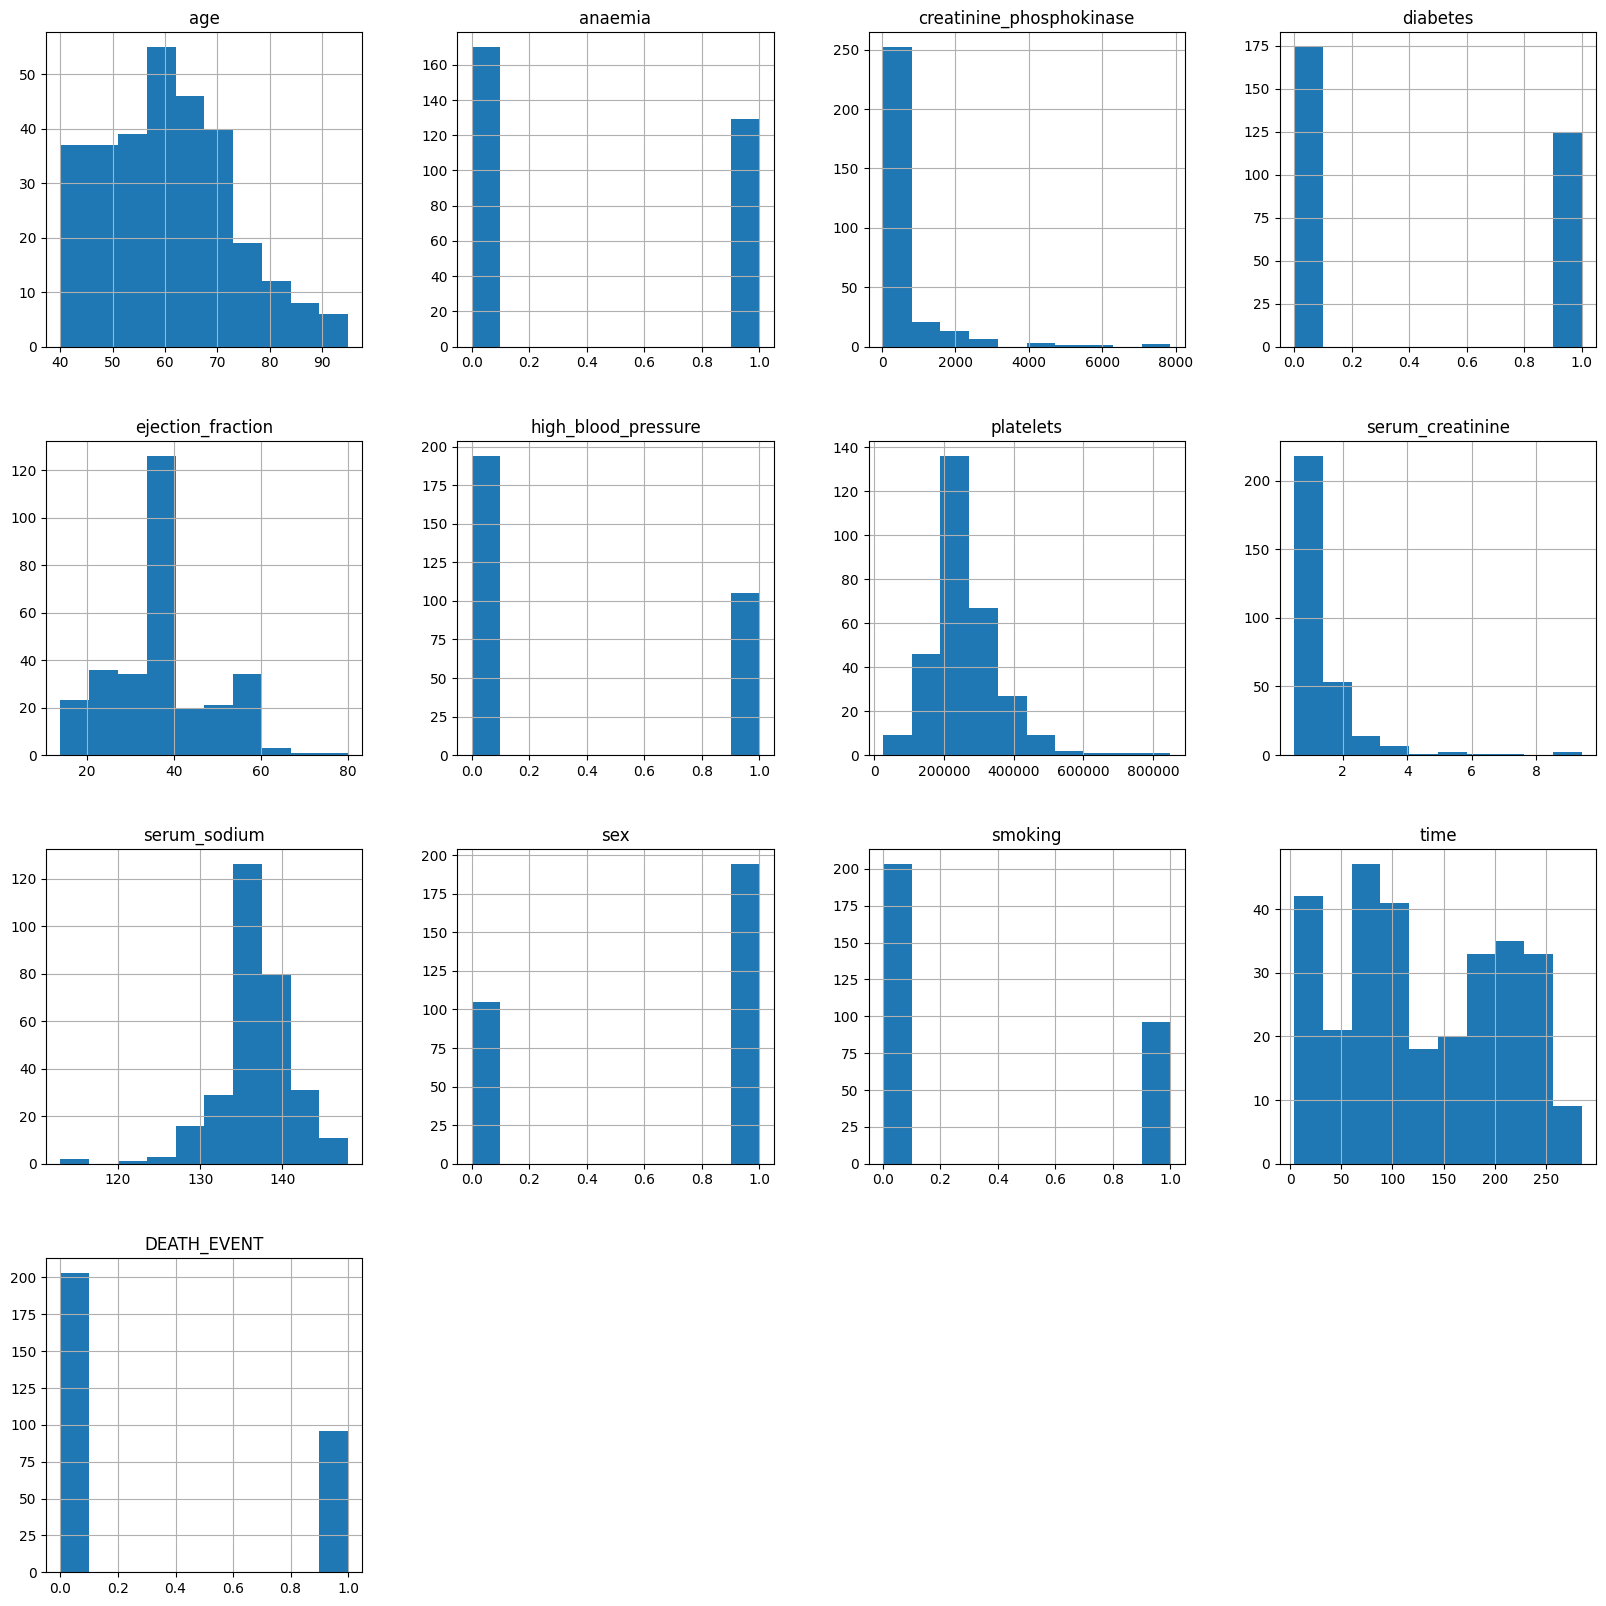

In [ ]:
heart_failure.hist(figsize=(20,20))  # Histogrammes des attributs
plt.plot()

In [33]:
heart_failure.corr() # Matrice de corrélation

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068,0.253729
anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414,0.066270
creatinine_phosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346,0.062728
diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726,-0.001943
ejection_fraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729,-0.268603
high_blood_pressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439,0.079351
platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514,-0.049139
serum_creatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315,0.294278
serum_sodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640,-0.195204
sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608,-0.004316


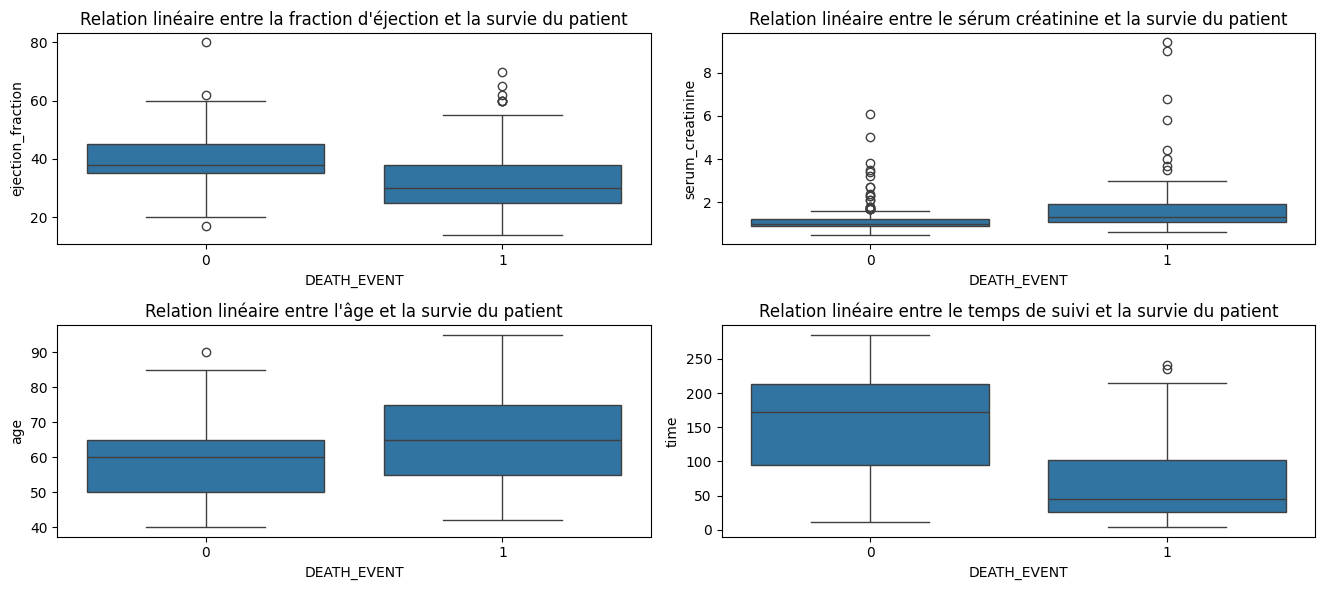

In [ ]:
plt.figure(figsize=(20, 6))

# Boîte a moustaches entre l'attribut DEATH_EVENT et ejection_fraction
plt.subplot(2, 3, 1)
sns.boxplot(x="DEATH_EVENT", y="ejection_fraction", data=heart_failure)
plt.title("Relation linéaire entre la fraction d'éjection et la survie du patient")

# Boîte a moustaches entre l'attribut DEATH_EVENT et serum_creatinine
plt.subplot(2, 3, 2)
sns.boxplot(x="DEATH_EVENT", y="serum_creatinine", data=heart_failure)
plt.title("Relation linéaire entre le sérum créatinine et la survie du patient")

# Boîte a moustaches entre l'attribut DEATH_EVENT et age
plt.subplot(2, 3, 4)
sns.boxplot(x="DEATH_EVENT", y="age", data=heart_failure)
plt.title("Relation linéaire entre l'âge et la survie du patient")

# Boîte a moustaches entre l'attribut DEATH_EVENT et time
plt.subplot(2, 3, 5)
sns.boxplot(x="DEATH_EVENT", y="time", data=heart_failure)
plt.title("Relation linéaire entre le temps de suivi et la survie du patient")

plt.tight_layout()

# Approches testées

## Partie 1 : Approche naïve

### Création des ensembles d'entraînement/test, *Feature scaling*

In [34]:
X_train_default, X_test_default, y_train_default, y_test_default = split_and_scale(X, y, scaling=False, stratify=y)

### Entraînements/Chargement des modèles

In [35]:
# Pour l'entraînement
_, default_models, default_results_dict = fit_scores(X_train_default, X_test_default, y_train_default, y_test_default, builders, None, metrics)

c:\Users\nabil\anaconda3\envs\hands-on-machine-learning\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Pour le chargement
default_models = load_models(extra='default')
default_results_dict = compute_metrics(X_test_default, y_test_default, metrics, default_models)

Le warning est issu du *SVC* qui effectue tout le temps les mêmes prédictions, ce qui résulte en une division par zéro de la métrique *precision*.

### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.599,0.688,0.833,0.846,0.579,0.765
RandomForestClassifier,0.600,0.706,0.833,0.800,0.632,0.779
XGBClassifier,0.599,0.688,0.833,0.846,0.579,0.765
SVC,0.000,0.000,0.683,0.000,0.000,0.500


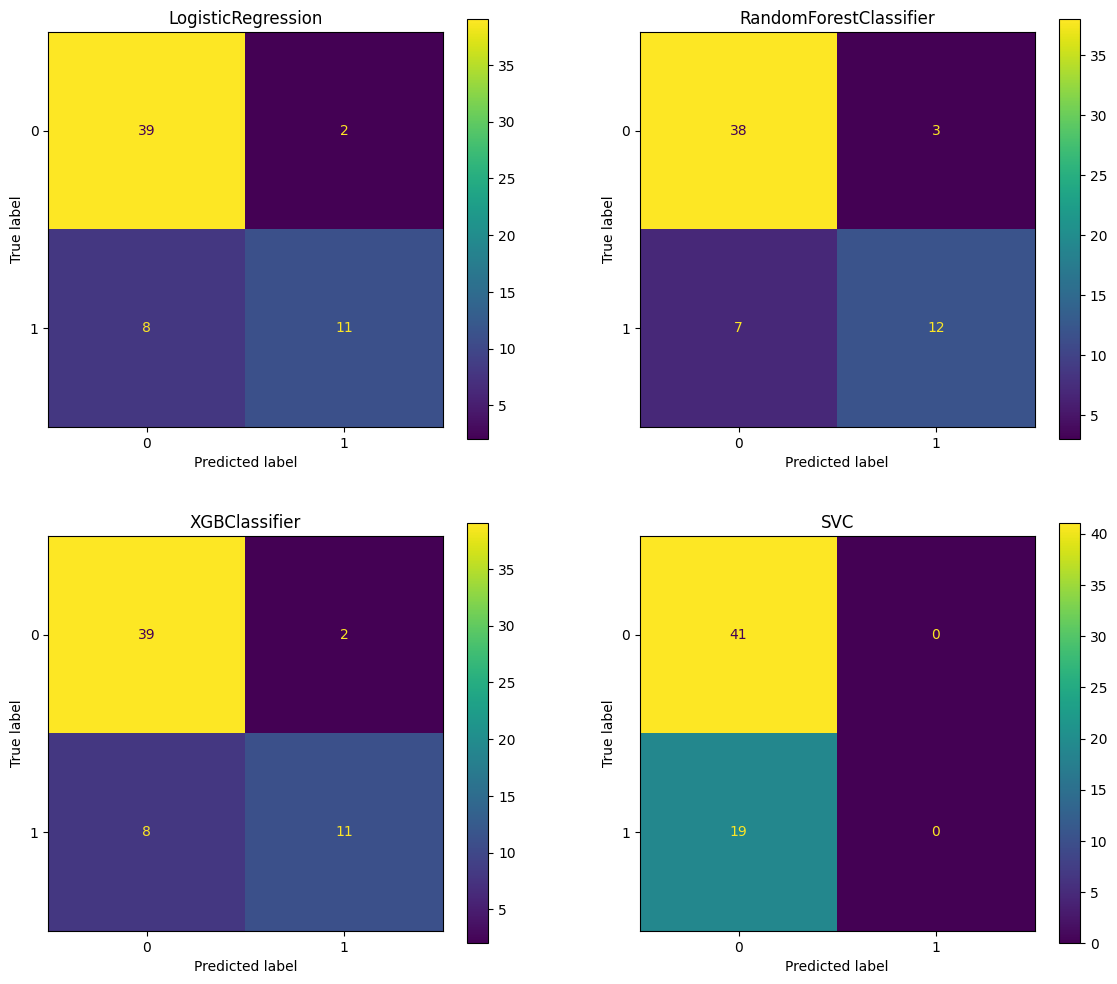

In [38]:
display_confusion_matrices(X_test_default, y_test_default, default_models)
dataframe_from_results(default_results_dict, metrics, default_models)

## Partie 2 : Approches stratégiques (avec *Feature scaling* & recherche d'hyperparamètres)

### Approche 1 : *Feature scaling* & recherche d'hyperparamètres **uniquement**

#### Création des ensembles d'entraînement/test, *Feature scaling*

In [39]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = split_and_scale(X, y, stratify=y)

#### Entraînements/Chargement des modèles

In [40]:
# Pour l'entraînement
scaled_histories, scaled_models, scaled_results_dict = fit_scores(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, builders, grids, metrics)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Pour le chargement
scaled_models = load_models(extra='scaled')
scaled_results_dict = compute_metrics(X_test_scaled, y_test_scaled, metrics, scaled_models)

#### Paramètres

In [44]:
print_params(scaled_histories)

{'C': 0.01, 'class_weight': None, 'max_iter': 25, 'solver': 'liblinear'}
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
{'eta': 0.2, 'gamma': 5, 'lambda': 1, 'max_depth': 2}
{'C': 1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


#### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.555,0.645,0.817,0.833,0.526,0.739
RandomForestClassifier,0.556,0.667,0.817,0.786,0.579,0.753
XGBClassifier,0.561,0.621,0.817,0.900,0.474,0.725
SVC,0.465,0.552,0.783,0.800,0.421,0.686


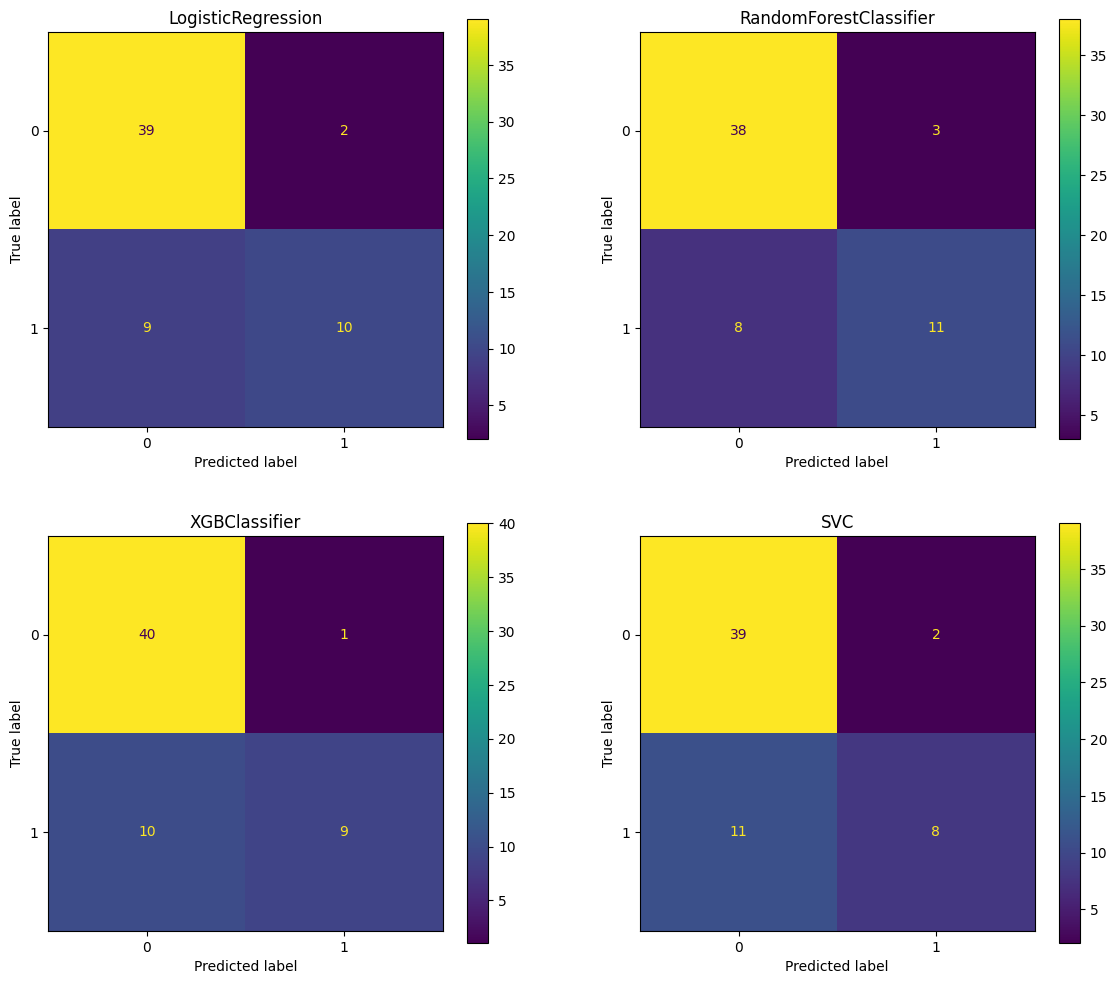

In [19]:
display_confusion_matrices(X_test_scaled, y_test_scaled, scaled_results_dict, scaled_models)
dataframe_from_results(scaled_results_dict, metrics, scaled_models)

#### Caractéristiques importantes de XGBClassifier

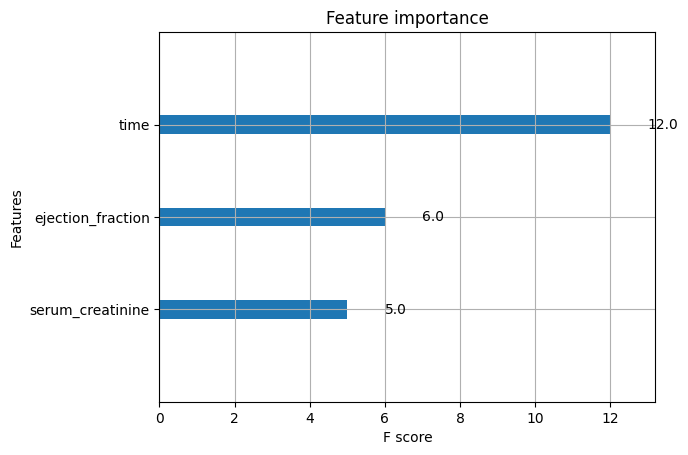

In [32]:
# Affichage des caractéristiques les plus importantes de XGBClassifier
scaled_xgbc = scaled_models[2]
scaled_xgbc.get_booster().feature_names = features  # Binding des noms des features 
xgb.plot_importance(scaled_xgbc);  # Affichage de l'histogramme des caractéristiques

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

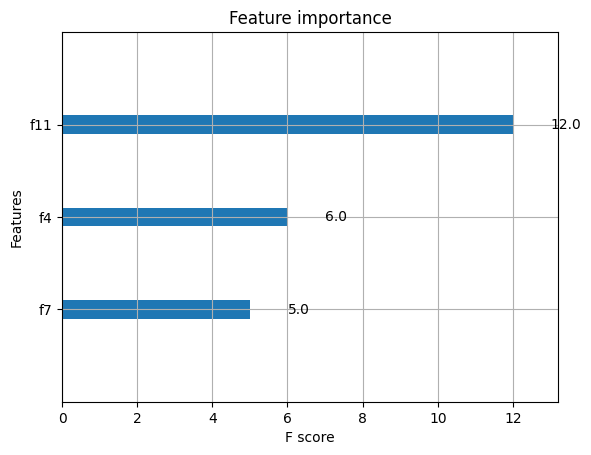

### Approche n°2 : Utilisation de *ejection_fraction*, *serum_creatinine* et *time*

#### Création du dataset réduit

In [59]:
three_best_features = ['ejection_fraction','serum_creatinine','time']
X_three_best_features = X[three_best_features]

#### Création des ensembles d'entraînement/test, *Feature scaling*

In [49]:
X_train_three_best_features, X_test_three_best_features, y_train_three_best_features, y_test_three_best_features = split_and_scale(X_three_best_features, y, stratify=y)

#### Entraînements/Chargement des modèles

In [50]:
# Pour l'entraînement
three_best_features_histories, three_best_features_models, three_best_features_results_dict = fit_scores(X_train_three_best_features, X_test_three_best_features, y_train_three_best_features, y_test_three_best_features, builders, grids, metrics)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Pour le chargement
three_best_features_models = load_models(extra='three_best_features')
three_best_features_results_dict = compute_metrics(X_test_three_best_features, y_test_three_best_features, metrics, three_best_features_models)

#### Paramètres

In [55]:
print_params(three_best_features_histories)

{'C': 1.0, 'class_weight': None, 'max_iter': 25, 'solver': 'lbfgs'}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
{'eta': 0.2, 'gamma': 0, 'lambda': 50, 'max_depth': 2}
{'C': 0.1, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


#### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.555,0.645,0.817,0.833,0.526,0.739
RandomForestClassifier,0.641,0.727,0.850,0.857,0.632,0.791
XGBClassifier,0.603,0.667,0.833,0.909,0.526,0.751
SVC,0.511,0.600,0.800,0.818,0.474,0.712


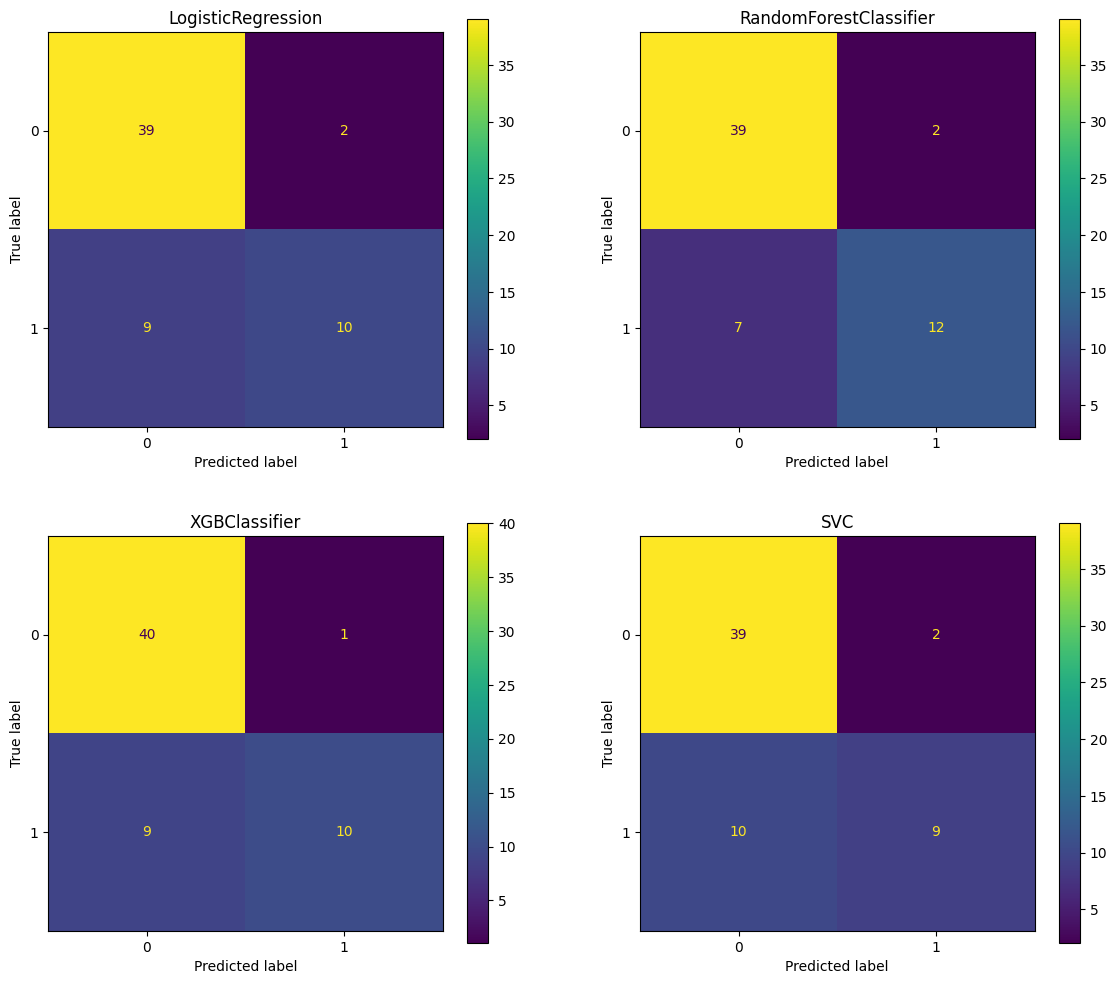

In [62]:
display_confusion_matrices(X_test_three_best_features, y_test_three_best_features, three_best_features_models)
dataframe_from_results(three_best_features_results_dict, metrics, three_best_features_models)

### Approche n°3 : Utilisation de *ejection_fraction* et *serum_creatinine*

#### Création du dataset réduit

In [63]:
two_best_features = ['ejection_fraction','serum_creatinine']
X_two_best_features = X[two_best_features]

#### Création des ensembles d'entraînement/test, *Feature scaling*

In [64]:
X_train_two_best_features, X_test_two_best_features, y_train_two_best_features, y_test_two_best_features = split_and_scale(X_two_best_features, y, stratify=y)

#### Entraînements/Chargement des modèles

In [59]:
# Pour l'entraînement
two_best_features_histories, two_best_features_models, two_best_features_results_dict = fit_scores(X_train_two_best_features, X_test_two_best_features, y_train_two_best_features, y_test_two_best_features, builders, grids, metrics)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Pour le chargement
two_best_features_models = load_models(extra='two_best_features')
two_best_features_results_dict = compute_metrics(X_test_two_best_features, y_test_two_best_features, metrics, two_best_features_models)

#### Paramètres

In [107]:
print_params(two_best_features_histories)

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 25, 'solver': 'lbfgs'}
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
{'eta': 0.4, 'gamma': 0, 'lambda': 50, 'max_depth': 2}
{'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


#### Frontière de décision

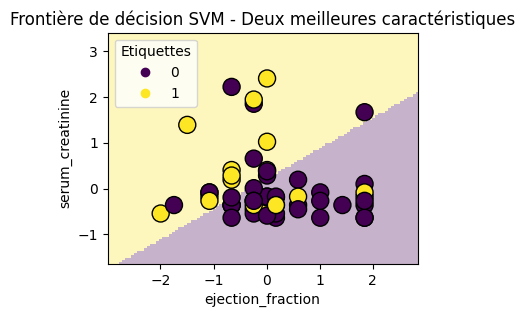

In [97]:
two_best_features_svc = two_best_features_models[3]
fig, ax = plt.subplots(figsize=(4, 3))
x_min, x_max, y_min, y_max = np.min(X_test_two_best_features[:,0])-1, np.max(X_test_two_best_features[:,0])+1, np.min(X_test_two_best_features[:,1])-1, np.max(X_test_two_best_features[:,1])+1
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

common_params = {"estimator": two_best_features_svc, "X": X_test_two_best_features, "ax": ax}
DecisionBoundaryDisplay.from_estimator(
    **common_params,
    response_method="predict",
    plot_method="pcolormesh",
    alpha=0.3,
)

scatter = ax.scatter(X_test_two_best_features[:,0], X_test_two_best_features[:,1], s=150, c=y_test_two_best_features, label=two_best_features, edgecolors="k")
ax.set_xlabel(two_best_features[0])
ax.set_ylabel(two_best_features[1])
ax.legend(*scatter.legend_elements(), loc="upper left", title="Etiquettes")
ax.set_title("Frontière de décision SVM - Deux meilleures caractéristiques")
plt.show()

#### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.322,0.558,0.683,0.500,0.632,0.669
RandomForestClassifier,0.418,0.533,0.767,0.727,0.421,0.674
XGBClassifier,0.302,0.485,0.717,0.571,0.421,0.637
SVC,0.327,0.550,0.700,0.524,0.579,0.668


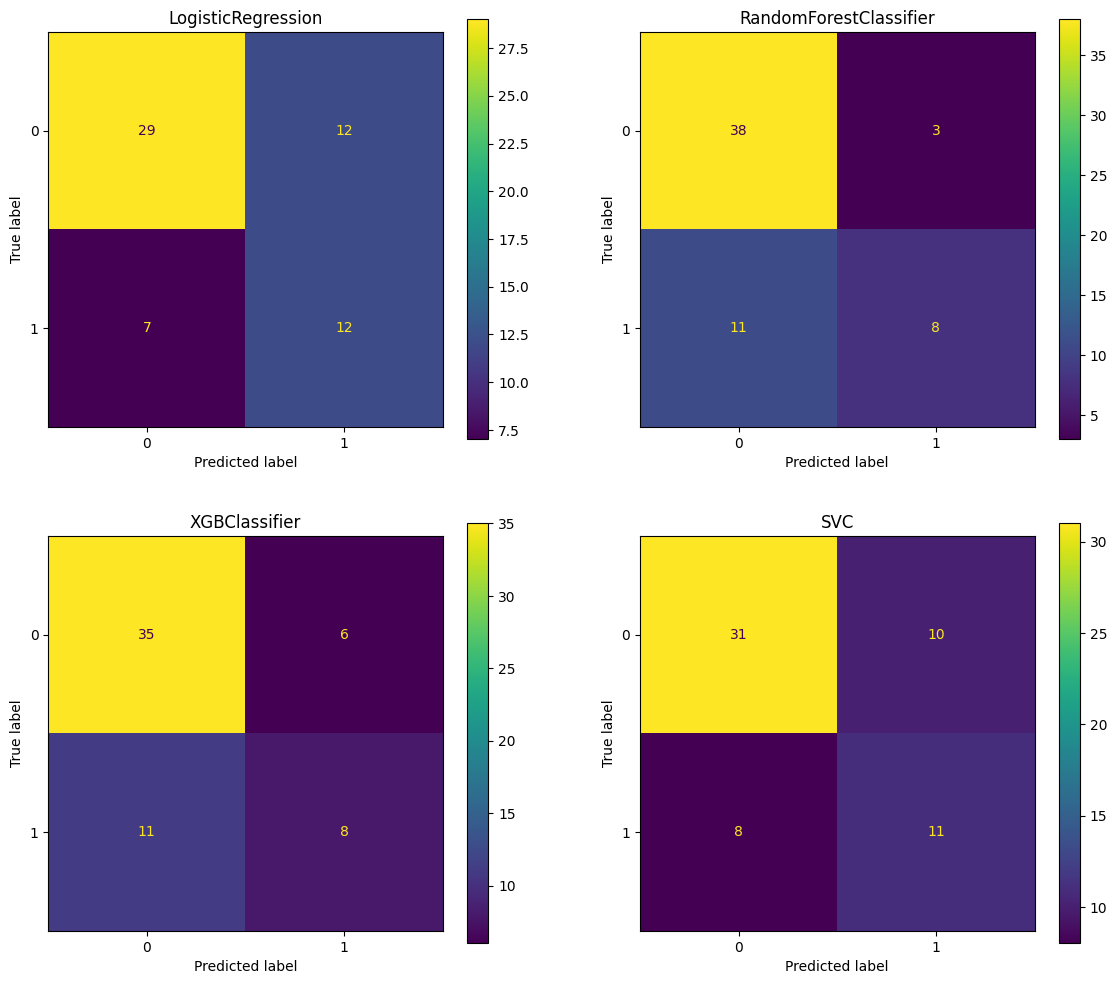

In [65]:
display_confusion_matrices(X_test_two_best_features, y_test_two_best_features, two_best_features_results_dict, two_best_features_models)
dataframe_from_results(two_best_features_results_dict, metrics, two_best_features_models)

### Approche n°4 : Oversampling

#### Création des ensembles d'entraînement/test, *Feature scaling*

In [115]:
X_train_prepared_oversampled, X_test_oversampled, y_train_prepared_oversampled, y_test_oversampled = split_and_scale(X, y, stratify=y)

#### Oversampling

In [116]:
oversampler = RandomOverSampler(random_state=RANDOM_SEED)

X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_prepared_oversampled, y_train_prepared_oversampled)

#### Entraînements/Chargement des modèles

In [117]:
# Pour l'entraînement
oversampled_histories, oversampled_models, oversampled_results_dict = fit_scores(X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled, builders, grids, metrics)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Pour l'entraînement
oversampled_models = load_models(extra='oversampled')
oversampled_results_dict = compute_metrics(X_test_oversampled, y_test_oversampled, metrics, oversampled_models)

#### Paramètres

In [118]:
print_params(oversampled_histories)

{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 25, 'solver': 'liblinear'}
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
{'eta': 0.2, 'gamma': 0, 'lambda': 10, 'max_depth': 6}
{'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


#### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.552,0.700,0.80,0.667,0.737,0.783
RandomForestClassifier,0.643,0.743,0.85,0.812,0.684,0.806
XGBClassifier,0.643,0.743,0.85,0.812,0.684,0.806
SVC,0.400,0.571,0.75,0.625,0.526,0.690


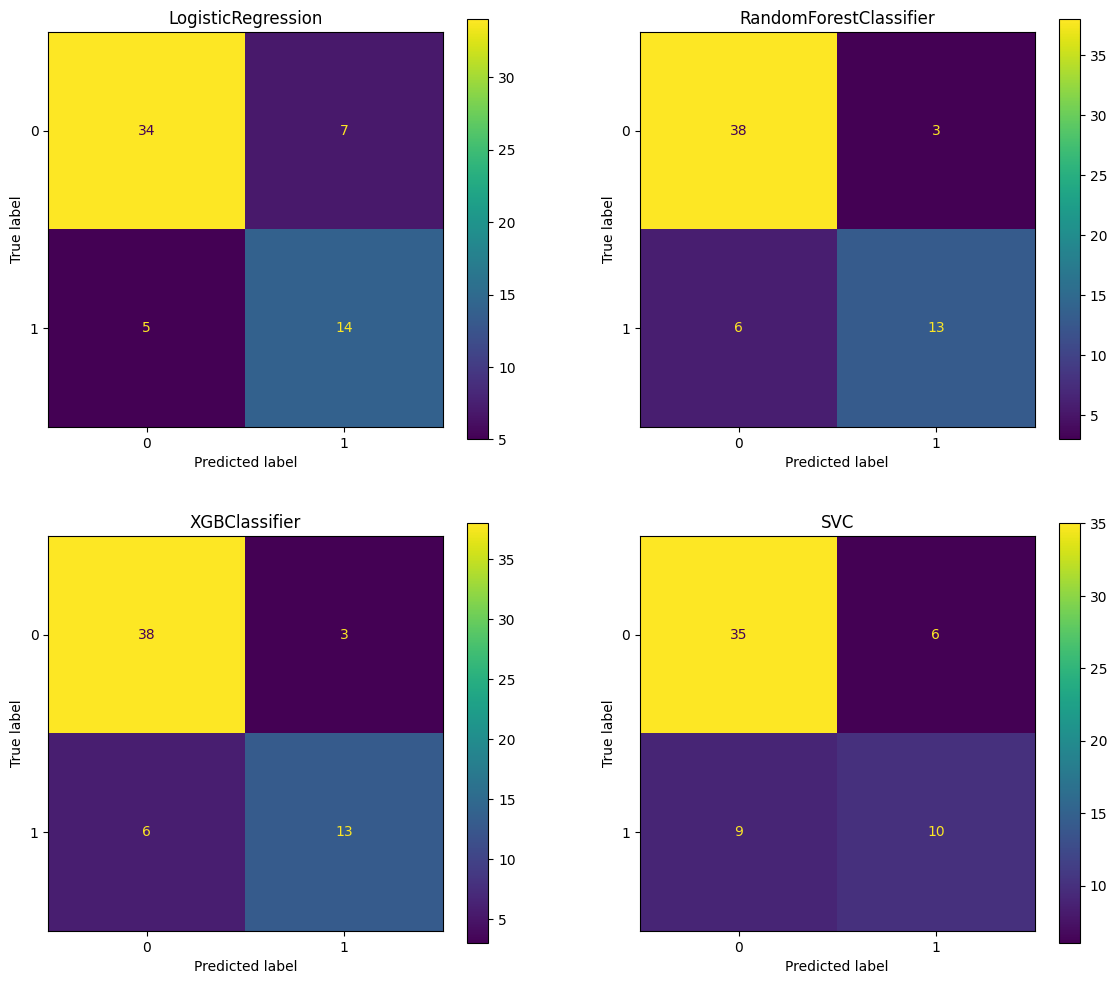

In [120]:
display_confusion_matrices(X_test_oversampled, y_test_oversampled, oversampled_results_dict, oversampled_models)
dataframe_from_results(oversampled_results_dict, metrics, oversampled_models)

### Approche n°5 : Undersampling

#### Création des ensembles d'entraînement/test, *Feature scaling*

In [46]:
X_train_prepared_undersampled, X_test_undersampled, y_train_prepared_undersampled, y_test_undersampled = split_and_scale(X, y, stratify=y)

#### Undersampling

In [47]:
undersampler = RandomUnderSampler(random_state=RANDOM_SEED)

X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_prepared_undersampled, y_train_prepared_undersampled)

#### Entraînements/Chargement des modèles

In [48]:
# Pour l'entraînement
undersampled_histories, undersampled_models, undersampled_results_dict = fit_scores(X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled, builders, grids, metrics)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Pour le chargement
undersampled_models = load_models(extra='undersampled')
undersampled_results_dict = compute_metrics(X_test_undersampled, y_test_undersampled, metrics, undersampled_models)

#### Paramètres

In [51]:
print_params(undersampled_histories)

{'C': 1.0, 'class_weight': None, 'max_iter': 25, 'solver': 'lbfgs'}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
{'eta': 0.4, 'gamma': 0, 'lambda': 50, 'max_depth': 4}
{'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


#### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.447,0.611,0.767,0.647,0.579,0.716
RandomForestClassifier,0.538,0.684,0.800,0.684,0.684,0.769
XGBClassifier,0.606,0.722,0.833,0.765,0.684,0.793
SVC,0.384,0.579,0.733,0.579,0.579,0.692


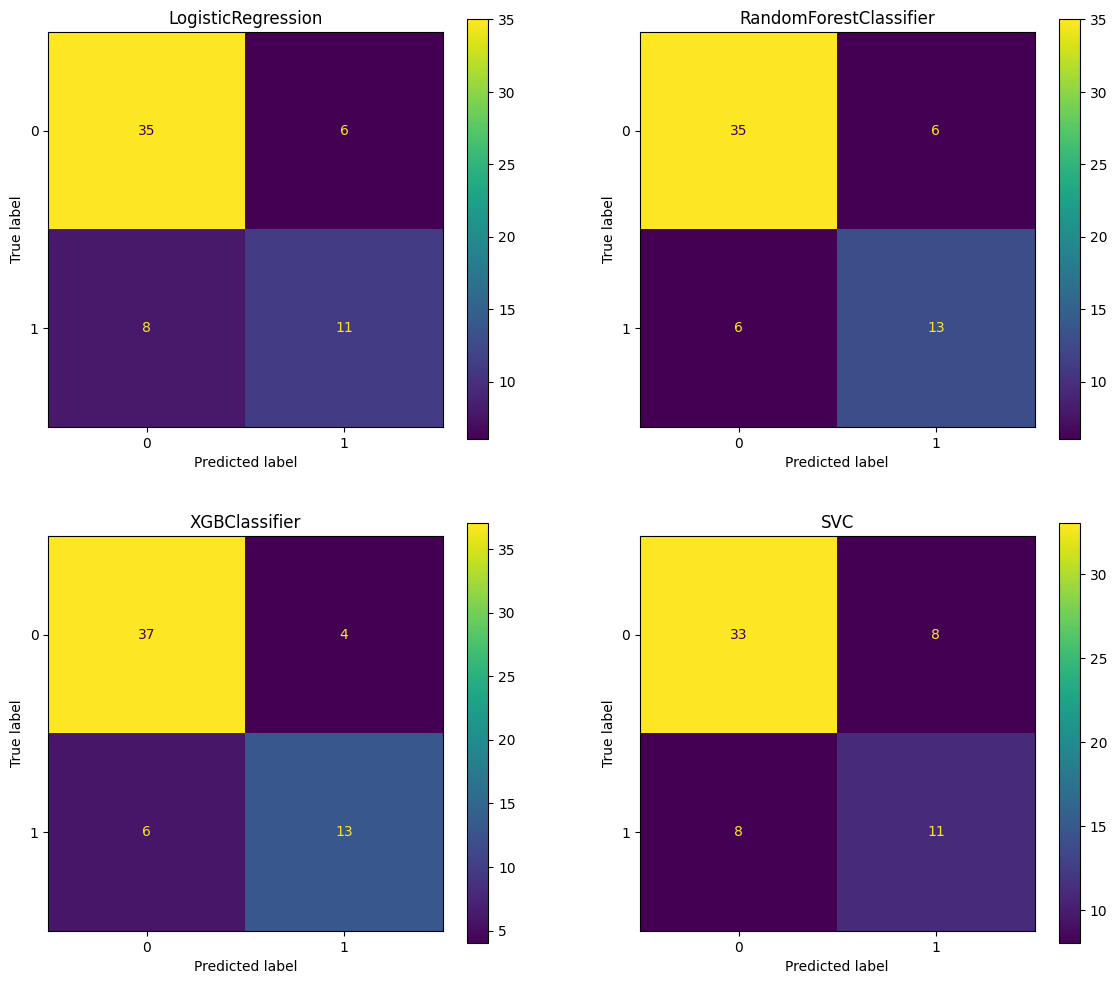

In [50]:
display_confusion_matrices(X_test_undersampled, y_test_undersampled, undersampled_models)
dataframe_from_results(undersampled_results_dict, metrics, undersampled_models)

### Approche n°6 : SMOTE

#### Création des ensembles d'entraînement/test, *Feature scaling*

In [52]:
X_train_prepared_smote, X_test_smote, y_train_prepared_smote, y_test_smote = split_and_scale(X, y, stratify=y)

#### SMOTE

In [53]:
smote = SMOTE(random_state=RANDOM_SEED)

X_train_smote, y_train_smote = smote.fit_resample(X_train_prepared_smote, y_train_prepared_smote)

#### Entraînements/Chargement des modèles

In [54]:
# Pour l'entraînement
smote_histories, smote_models, smote_results_dict = fit_scores(X_train_smote, X_test_smote, y_train_smote, y_test_smote, builders, grids, metrics)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Pour le chargement
smote_models = load_models(extra='smote')
smote_results_dict = compute_metrics(X_test_smote, y_test_smote, metrics, smote_models)

#### Paramètres

In [64]:
print_params(smote_histories)

{'C': 0.1, 'class_weight': None, 'max_iter': 25, 'solver': 'liblinear'}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 50}
{'eta': 0.8, 'gamma': 0, 'lambda': 0.1, 'max_depth': 4}
{'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


#### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.447,0.611,0.767,0.647,0.579,0.716
RandomForestClassifier,0.526,0.667,0.800,0.706,0.632,0.755
XGBClassifier,0.556,0.667,0.817,0.786,0.579,0.753
SVC,0.400,0.571,0.750,0.625,0.526,0.690


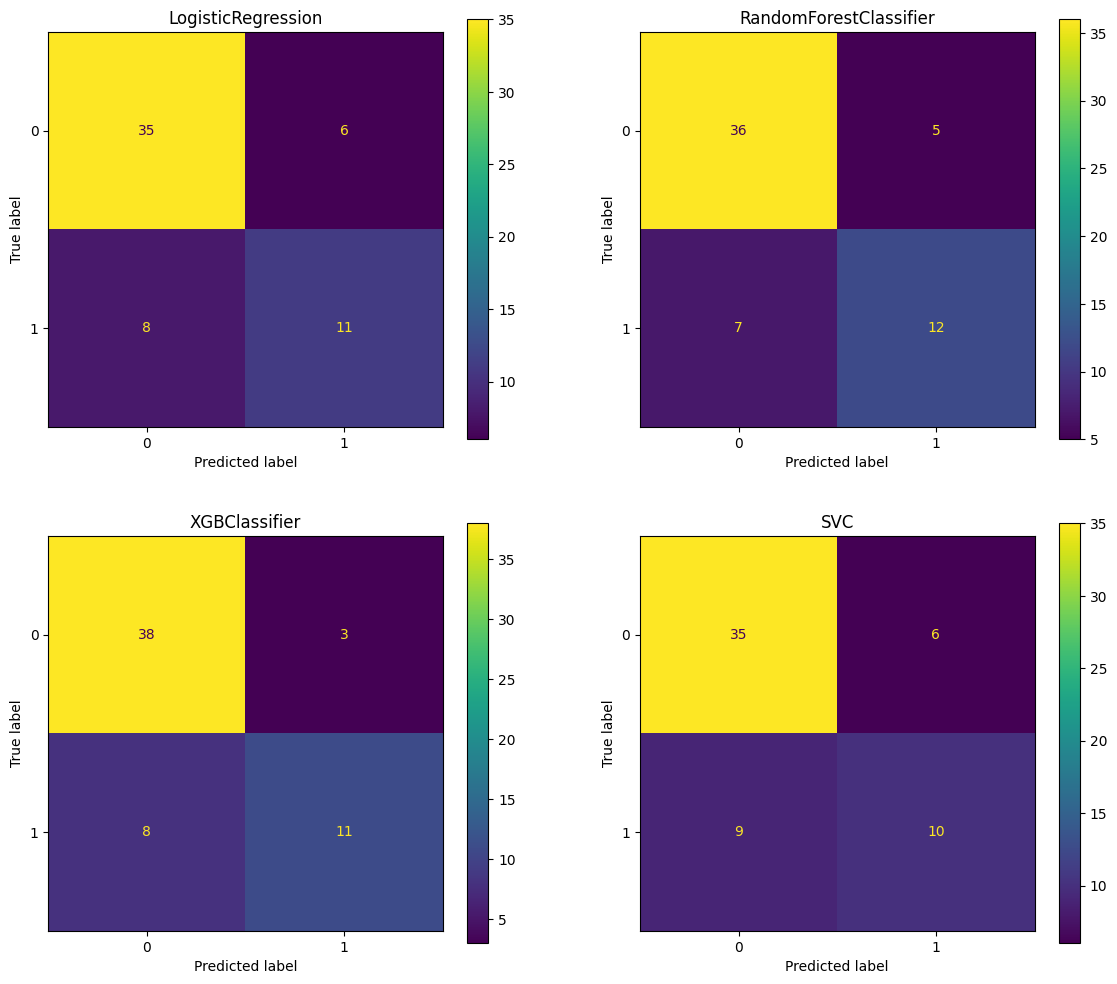

In [56]:
display_confusion_matrices(X_test_smote, y_test_smote, smote_models)
dataframe_from_results(smote_results_dict, metrics, smote_models)

## Partie 3 : Approche finale - Oversampling, *ejection_fraction*, *serum_creatinine* et *time*

### Création des ensembles d'entraînement/test, *Feature scaling*

In [60]:
X_train_three_best_features_prepared_oversampled, X_test_three_best_features_oversampled, y_train_three_best_features_prepared_oversampled, y_test_three_best_features_oversampled = split_and_scale(X_three_best_features, y, stratify=y)

### Oversampler

In [61]:
oversampler2 = RandomOverSampler(random_state=RANDOM_SEED)

X_train_three_best_features_oversampled, y_train_three_best_features_oversampled = oversampler2.fit_resample(X_train_three_best_features_prepared_oversampled, y_train_three_best_features_prepared_oversampled)

### Entraînements/Chargement des modèles

In [62]:
# Pour l'entraînement
three_best_features_oversampled_histories, three_best_features_oversampled_models, three_best_features_oversampled_results_dict = fit_scores(X_train_three_best_features_oversampled, X_test_three_best_features_oversampled, y_train_three_best_features_oversampled, y_test_three_best_features_oversampled, builders, grids, metrics)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# Pour le chargement
three_best_features_oversampled_models = load_models(extra='three_best_features_oversampled')
three_best_features_oversampled_results_dict = compute_metrics(X_test_three_best_features_oversampled, y_test_three_best_features_oversampled, metrics, three_best_features_oversampled_models)

### Paramètres

In [67]:
print_params(three_best_features_oversampled_histories)

{'C': 10, 'class_weight': 'balanced', 'max_iter': 25, 'solver': 'lbfgs'}
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
{'eta': 2, 'gamma': 0, 'lambda': 1, 'max_depth': 6}
{'C': 1, 'class_weight': None, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


### Résultats

,matthews_corrcoef,f1_score,accuracy_score,precision_score,recall_score,roc_auc_score
LogisticRegression,0.526,0.667,0.800,0.706,0.632,0.755
RandomForestClassifier,0.643,0.743,0.850,0.812,0.684,0.806
XGBClassifier,0.641,0.727,0.850,0.857,0.632,0.791
SVC,0.481,0.629,0.783,0.688,0.579,0.728


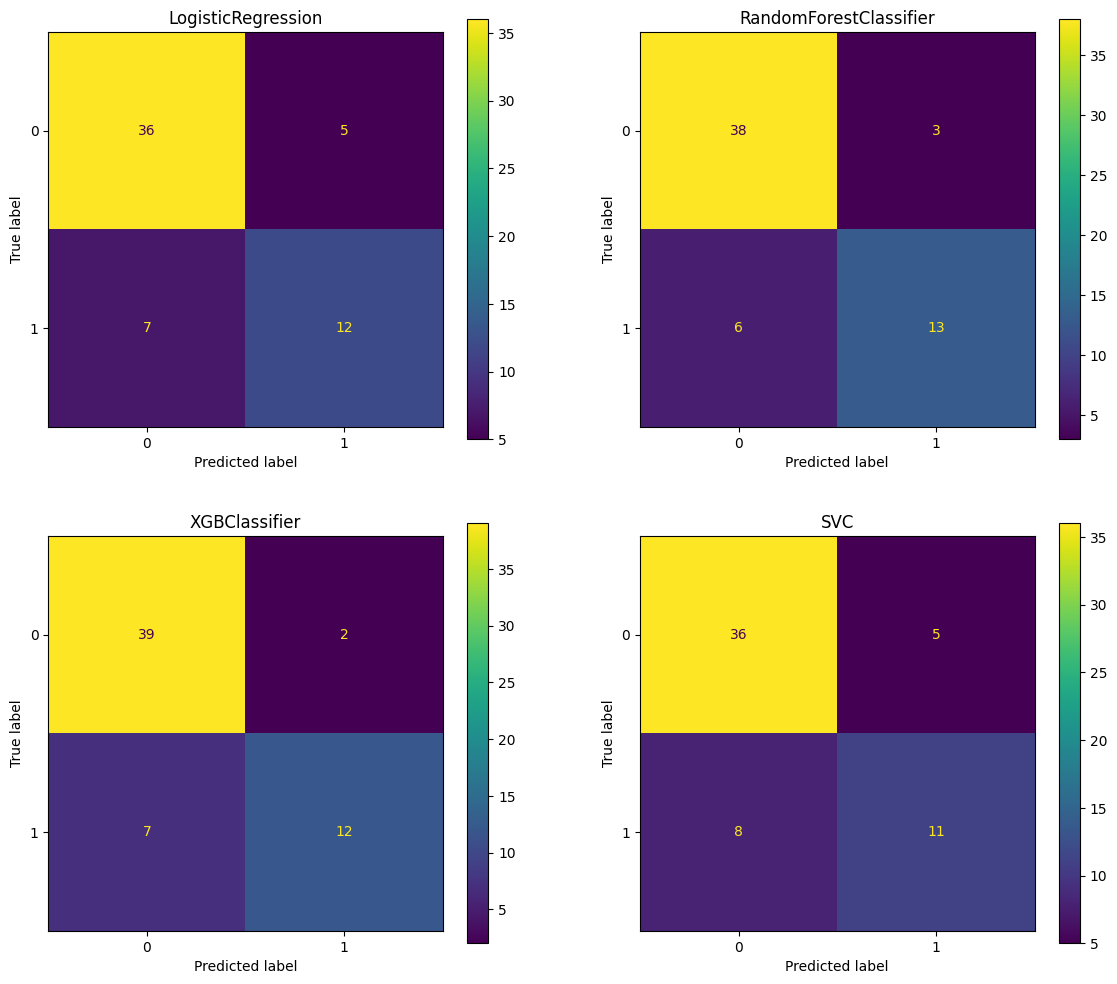

In [66]:
display_confusion_matrices(X_test_three_best_features_oversampled, y_test_three_best_features_oversampled, three_best_features_oversampled_models)
dataframe_from_results(three_best_features_oversampled_results_dict, metrics, three_best_features_oversampled_models)